# !pip

In [ ]:
!pip install --upgrade lightgbm
!pip install -qqq transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 3.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 4.7 MB 4.2 MB/s 
     |████████████████████████████████| 120 kB 57.2 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 


# IMPORT文

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import transformers
from transformers import BertTokenizer

from lightgbm import early_stopping
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.simplefilter('ignore')

In [ ]:
lgb.__version__

'3.3.2'

# データの読み込み

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Competitions/SIGNATE/MUFG/input/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Competitions/SIGNATE/MUFG/input/test.csv")
df_sub = pd.read_csv("/content/drive/MyDrive/Competitions/SIGNATE/MUFG/input/sample_submit.csv", header=None)

#方針
- id: 学習時落とす
- goal: ラベルエンコーディング or 真ん中の値(100000+は100001とする)
- country: ラベルエンコーディング
- duration: そのまま
- category1: ラベルエンコーディング
- category2: ラベルエンコーディング
- html_content: いったん落として予測 ⇒ 新たな特徴量(文字数・htmlタグの個数・単語数など) ⇒ モデル(deberta等)を利用

# EDA終えての結果・考察
- 欠損値はない
- html_contentが全く同じものがある(テンプレで投稿している可能性)
- カテゴリ変数はtrain, testともにほぼかぶっている
- 数値変数のdurationの分布もtrainとtestでそこまで変わらない

In [ ]:
df_train

,id,goal,country,duration,category1,category2,html_content,state
0,train_00000,20001-21000,US,45,art,mixed media,"<div class=""contents""><div><p><a href=""http://...",1
1,train_00001,19001-20000,US,59,food,restaurants,"<div class=""contents""><div><p>Cultural Pretzel...",0
2,train_00002,2001-3000,US,38,art,performance art,"<div class=""contents""><div><p>I want to perfor...",0
3,train_00003,1001-2000,US,30,art,mixed media,"<div class=""contents""><div><div class=""templat...",1
4,train_00004,1001-2000,US,29,film & video,webseries,"<div class=""contents""><div><p>The story of the...",1
...,...,...,...,...,...,...,...,...
9786,train_09786,1-1000,US,15,music,electronic music,"<div class=""contents""><div><p>So the story beh...",0
9787,train_09787,3001-4000,CA,30,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0
9788,train_09788,100000+,GB,30,technology,software,"<div class=""contents""><div><p>We don't think a...",0
9789,train_09789,79001-80000,US,35,technology,gadgets,"<div class=""contents""><div><a href=""http://dum...",1


In [ ]:
df_test

,id,goal,country,duration,category1,category2,html_content
0,test_00000,5001-6000,FR,30,dance,performances,"<div class=""contents""><div><p>Bonjour ,</p><p>..."
1,test_00001,6001-7000,GB,23,publishing,children's books,"<div class=""contents""><div><p><span class=""bol..."
2,test_00002,6001-7000,GB,30,theater,plays,"<div class=""contents""><div><p>COW is a rural t..."
3,test_00003,1001-2000,CA,14,art,digital art,"<div class=""contents""><div><p>I've been creati..."
4,test_00004,1-1000,US,30,music,hip-hop,"<div class=""contents""><div><div class=""templat..."
...,...,...,...,...,...,...,...
9795,test_09795,4001-5000,US,29,music,world music,"<div class=""contents""><div><h1 class=""page-anc..."
9796,test_09796,10001-11000,US,30,publishing,children's books,"<div class=""contents""><div><p><span class=""bol..."
9797,test_09797,2001-3000,US,30,music,hip-hop,"<div class=""contents""><div><h1 class=""page-anc..."
9798,test_09798,7001-8000,US,30,theater,plays,"<div class=""contents""><div><p>Have you ever re..."


# 前処理
1. 特徴量生成
2. ラベルエンコーディング
3. 不要なカラムの削除


In [ ]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [ ]:
df.iloc[0]["html_content"]

'<div class="contents"><div><p><a href="http://dummy.com">http://dummy.com<p>In its first year, The Shillito\'s Elves Display won an international \ndesign award for Shillito\'s department store.\xa0 The elves display is arts\n and crafts at its finest.\xa0 The mixed media exhibit displays the talents\n of local fine arts graduates, and the display, while "folksy", is as \ntechnologically advanced as Disney World\'s famous "It\'s a Small World" \nride. </p><p>The Shillito\'s Elves attracted close to 100,000 people each\n year.\xa0 It was one of the most beloved Christmas traditions in \nCincinnati.\xa0 For many in the Cincinnati area, it is a fond childhood \nholiday memory and one that they would love to share with their own \nfamilies.\xa0 In the next 40 days, we are asking for your help to make the \nentire display viewable again for the first time in 25 years.\xa0 In order \nto make this happen, we must meet our financial goal.\xa0 </p><p>Your money will be used in the following wa

## 1. 特徴量生成

### bertを使ってhtml_contentをベクトル変換

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name="bert-base-uncased", max_len=128):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = max_len

    def vectorize(self, sentence: str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
BSV = BertSequenceVectorizer(
    model_name="bert-base-multilingual-uncased",
    max_len=512)
features = np.stack(
    df["html_content"].progress_map(lambda x: BSV.vectorize(x).reshape(-1)).values
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/19591 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
cols_bert = ["html_vec"+str(i+1) for i in range(features.shape[1])]
df_bert = pd.DataFrame(features, columns=cols_bert)
df = pd.concat([df, df_bert], axis=1)

### ほかの特徴量作成

In [ ]:
# html_contentの文字数
df["char_len"] = df["html_content"].map(lambda x: len(x))

In [ ]:
# category1と2の掛け算
df["category_1×2"] = df["category1"] + df["category2"]

## 2. ラベルエンコーディング

In [ ]:
def label_encoding(df, column_list):
    for column in column_list:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df

In [ ]:
LABEL_LIST = ["goal", "country", "category1", "category2", "category_1×2"]
df = label_encoding(df, LABEL_LIST)

## 3. 不要なカラムの削除

In [ ]:
def drop_columns(df, columns):
    df = df.drop(labels=columns, axis=1)
    return df

In [ ]:
DROP_LIST = ["id", "html_content"]
df = drop_columns(df, DROP_LIST)

## dfをtrainとtestに分ける

In [ ]:
df_train_preprocessed = df.copy().iloc[:len(df_train)]
df_test_preprocessed = df.copy().drop("state", axis=1).iloc[len(df_train):].reset_index(drop=True)

In [ ]:
df_train_preprocessed.head()

,goal,country,duration,category1,category2,state,html_vec1,html_vec2,html_vec3,html_vec4,...,html_vec761,html_vec762,html_vec763,html_vec764,html_vec765,html_vec766,html_vec767,html_vec768,char_len,category_1×2
0,13,21,45,0,77,1.0,-0.008775,0.342385,-0.439762,-0.076453,...,-0.793728,-0.443016,-0.553126,-0.289216,-0.068710,0.386008,0.045541,-0.451307,1885,5
1,12,21,59,7,110,0.0,-0.007824,-0.126312,0.110633,-0.056152,...,-0.015535,-0.102644,0.059717,0.000654,-0.058138,0.057662,0.012196,-0.109577,1561,76
2,14,21,38,0,87,0.0,-0.273303,0.292223,-0.597911,0.065161,...,-0.581877,0.036350,-0.344476,-0.476880,0.022513,0.409317,-0.020618,-0.330200,2290,7
3,3,21,30,0,77,1.0,-0.140894,0.569699,-0.364222,0.209479,...,-0.607408,-0.062951,-0.503482,0.082443,0.152119,0.430510,0.222221,-0.625320,4681,5
4,3,21,29,6,139,1.0,0.039158,0.660504,0.020512,0.059146,...,-0.733717,-0.173551,-0.147747,0.066347,-0.027351,0.471819,0.538635,-0.567305,6225,67


In [ ]:
df_test_preprocessed.head()

,goal,country,duration,category1,category2,html_vec1,html_vec2,html_vec3,html_vec4,html_vec5,...,html_vec761,html_vec762,html_vec763,html_vec764,html_vec765,html_vec766,html_vec767,html_vec768,char_len,category_1×2
0,47,8,30,3,88,-0.103578,-0.123624,-0.277959,-0.131003,-0.713825,...,-0.470346,-0.461153,-0.200506,-0.271426,-0.489691,0.030993,-0.097700,-0.629975,2516,30
1,58,9,23,12,18,0.056785,0.774648,-0.366337,-0.094639,-1.197799,...,-0.483722,-0.276243,-0.461368,-0.164810,-0.254928,0.610946,0.444095,-0.164847,6252,120
2,58,9,30,14,95,0.070651,0.646020,-0.432890,-0.156159,-0.831253,...,-0.822963,-0.230631,0.219239,-0.061005,0.042105,0.613142,0.205670,-0.273780,5921,153
3,3,3,14,0,31,-0.051854,-0.142672,0.045751,-0.013201,-0.362305,...,-0.085278,-0.115565,-0.023162,-0.077179,-0.107508,-0.062157,0.008859,-0.047948,1587,2
4,0,21,30,10,59,-0.106943,-0.100001,0.016154,0.003113,-0.298593,...,-0.035502,-0.208952,-0.033146,0.114734,-0.140060,-0.067460,0.008508,0.108182,756,99


# モデリング

## metric

In [ ]:
def metric(y_true, y_pred):
    return f1_score(y_true, y_pred)

## LightGBM Class

In [ ]:
class LightGBM:
    def __init__(self, params=None):
        if params == None:
            self.params = {
                "objective": "binary", 
                "learning_rate": .1,
                "reg_lambda": .1,
                "reg_alpha": 0,
                "max_depth": 5, 
                "n_estimators": 10000, 
                "colsample_bytree": .5, 
                "min_child_samples": 10,
                "subsample_freq": 3,
                "subsample": .9,
                "importance_type": "gain", 
                "random_state": 1
            }
        else:
            self.params = params

    def fit(self, df):
        # dataset作成
        train_X = df.drop("state", axis=1)
        train_y = df["state"]

        self._feature_name = train_X.columns
        self.models = []
        scores = []

        kf = KFold(n_splits=4, shuffle=True, random_state=2022)
        for fold, (tr_idx, va_idx) in enumerate(kf.split(train_X)):
            tr_X, va_X = train_X.iloc[tr_idx], train_X.iloc[va_idx]
            tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
            self.model = lgb.LGBMModel(**self.params)
            self.model.fit(
                tr_X,
                tr_y,
                eval_set=[(va_X, va_y)],
                callbacks=[early_stopping(stopping_rounds=10, verbose=False), 
                            lgb.log_evaluation(period=0, show_stdv=False)]
            )
        
            self.pred_array = self.predict(va_X)
            self.y_pred = (self.predict(va_X) > 0.5)
            self.F1_score = metric(va_y, self.y_pred)

            scores.append(self.F1_score)
            self.models.append(self.model)

            print(f"fold{fold+1}-F1_score: {self.F1_score}")
        print(f"mean-F1_score: {sum(scores) / len(scores)}")

    def predict(self, df):
        test = df.values
        pred = self.model.predict(test)
        return pred
    
    def visualize_importance(self, top_num=10):
        
        fig, ax = plt.subplots(1, 1, figsize=(max(8, 1.2*top_num), 20))
        
        self._df_feature_importance = pd.DataFrame()
        for idx, clf  in enumerate(self.models):
            _df = pd.DataFrame()
            _df["feature_importance"] = clf.feature_importances_
            _df["feature_name"] = self._feature_name
            _df["fold"] = idx + 1
            self._df_feature_importance = pd.concat([self._df_feature_importance, _df])

        order = self._df_feature_importance.groupby("feature_name")["feature_importance"].sum()\
                                .sort_values(ascending=False).index[:top_num]

        sns.boxenplot(
            x="feature_importance", 
            y="feature_name", 
            data=self._df_feature_importance, 
            order=order, ax=ax
        )
        ax.grid()
        
        plt.show()

# Main

In [ ]:
# 学習の実行
model = LightGBM()
model.fit(df_train_preprocessed)

fold1-F1_score: 0.7345952476842531
fold2-F1_score: 0.7506112469437654
fold3-F1_score: 0.7535037098103874
fold4-F1_score: 0.7546862265688672
mean-F1_score: 0.7483491077518183


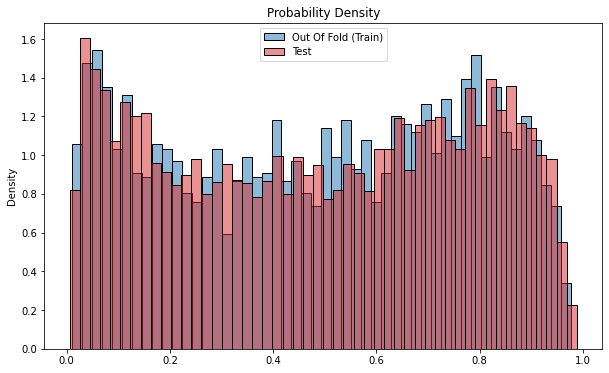

In [ ]:
pred_test = model.predict(df_test_preprocessed)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=model.pred_array, bins=50, alpha=0.5, ax=ax, stat="density", label="Out Of Fold (Train)", color="tab:blue")
sns.histplot(x=pred_test, bins=50, alpha=0.5, ax=ax, stat="density", label="Test", color="tab:red")

ax.set_title("Probability Density")
ax.legend()
plt.show()

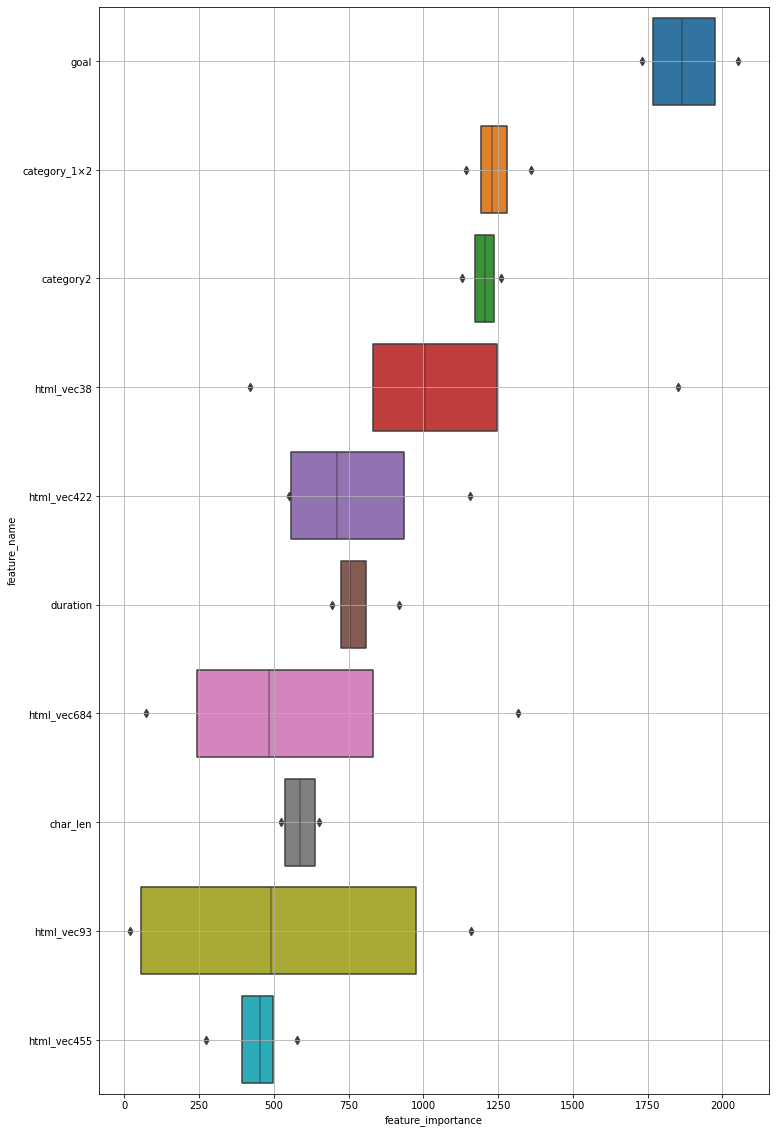

In [ ]:
model.visualize_importance()

In [ ]:
sub = df_sub.drop(1, axis=1)
sub[1] = np.where(pred_test >= 0.5, 1, 0)

In [ ]:
sub

,0,1
0,test_00000,1
1,test_00001,1
2,test_00002,1
3,test_00003,0
4,test_00004,0
...,...,...
9795,test_09795,1
9796,test_09796,1
9797,test_09797,0
9798,test_09798,1


In [ ]:
sub.to_csv("/content/drive/MyDrive/Competitions/SIGNATE/MUFG/submission/LightGBM_v3.csv", index=False)